In [2]:
#import libraries
# import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

# torch.__version__

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
import numpy as np

In [382]:
def fit_polynomial_sgd(X, t, M, lr, b):

    #combine dataset
    train_data = TensorDataset(X,t)

    #create batch loader
    train_loader = DataLoader(dataset = train_data, batch_size=b)

    #initialize weight
    w_hat = Variable(torch.ones(M, dtype = float), requires_grad = True)

    #Define loss func
    loss_fn = nn.SmoothL1Loss(reduction = 'sum')
    losses = []

    # define an optimizer to update param
    optimizer = optim.SGD([w_hat], lr=lr , weight_decay = 1)

    for epoch in range(1000):
        for x_train, y_train in train_loader:

            y_hat = polynomial_fun(w_hat,x_train)

            loss = loss_fn(y_train, y_hat)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss)

    return w_hat


    

#Task2

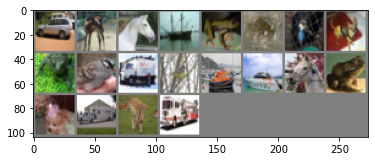

  car horse horse  ship  frog  frog  bird   dog  frog  bird truck  bird  ship  ship horse  frog   dog truck  deer truck


In [8]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
## cifar-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# example images
dataiter = iter(trainloader)
images, labels = dataiter.next()

im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
im.save("train_pt_images.jpg")
print('train_pt_images.jpg saved.')
print('Ground truth labels:' + ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


14.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

47.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

79.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
train_pt_images.jpg saved.
Ground truth labels: frog  bird horse  deer plane plane  frog  bird plane  ship   cat   car  deer plane   car  bird horse  frog  bird truck


In [3]:
#implement DenseNet architecture into image classification tutorial

import torch
import torch.nn as nn
import torch.nn.functional as F

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    def forward(self,x):
        print(x)
        print(x.shape)
        return x

class Dense_Layer(nn.Module):
    def __init__(self, n_in, n_out):
        super(Dense_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=T)
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False)
    def forward(self,x):
        out = self.conv(self.relu(self.bn(x)))
        x = torch.cat([x,out],1)
        return x

class Transition_Layer(nn.Sequential):
    def __init__(self, n_in, n_out):
        super(Transition_Layer, self).__init__()
        self.bn = nn.BatchNorm2d(n_in)
        self.relu = nn.ReLU(inplace=T)
        self.conv = nn.Conv2d(n_in, n_out,kernel_size=1,stride=1,padding = 0,bias=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.pool(self.conv(self.relu(self.bn(x))))
        return x

class Dense_Block(nn.Module):
    def __init__(self, n_in, growth):
        super(Dense_Block, self).__init__()
        self.layer = self.dense_block(n_in, growth)
    def dense_block(self, n_in, growth):
        layers = []
        for i in range(0,4):
            layers.append(Dense_Layer(n_in + i*growth, growth))
        return nn.Sequential(*layers)
    def forward(self,x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, n_channels, growth):
        super(DenseNet3, self).__init__()
        #initial convolution
        self.conv0 = nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1, bias=False)
        
        #first denseblock
        self.dense1 = Dense_Block(n_channels, growth)
        n_channels = int(n_channels + 4*growth)
        self.trans1 = Transition_Layer(n_channels, n_channels/2)
        n_channels = int(n_channels/2)

        #second denseblock
        self.dense2 = Dense_Block(n_channels, growth)
        n_channels = int(n_channels + 4*growth)
        self.trans2 = Transition_Layer(n_channels, n_channels/2)
        n_channels = int(n_channels/2)

        #third denseblock
        self.dense3 = Dense_Block(n_channels, growth)
        n_channels = int(n_channels + 4*growth)

        #global average pooling, classifier
        self.bnend =  nn.BatchNorm2d(n_channels)
        self.classifier = nn.Linear(n_channels, 10)

        def forward(self,x):
            out = self.conv0(x)
            print(out.shape)
            out = self.trans1(self.dense1(out))
            print(out.shape)
            out = self.trans2(self.dense2(out))
            out = self.dense3(out)
            out = F.relu(self.bnend(out))
            out = F.adaptive_avg_pool2d(out, (1,1))
            out = torch.flatten(out, 1)
            out = self.classifier(out)

            return out

In [11]:
for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    if i ==1:
        break

inputs

labels

tensor([0, 6, 3, 4, 4, 8, 6, 6, 0, 2, 5, 5, 7, 8, 4, 5, 7, 2, 7, 7])

In [13]:
inputs.shape

torch.Size([20, 3, 32, 32])

In [17]:
conv0 = nn.Conv2d(3, 32, kernel_size=3, stride = 1, padding=1, bias=False)

test = conv0(inputs)

test.shape

torch.Size([20, 32, 32, 32])

In [4]:
#image classification train

if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 20
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # example images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
    im.save("train_pt_images.jpg")
    print('train_pt_images.jpg saved.')
    print('Ground truth labels:' + ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


    ## cnn
    net = DenseNet3()


    ## loss and optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


    ## train
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Training done.')

    # save trained model
    torch.save(net.state_dict(), 'saved_model.pt')
    print('Model saved.')

Files already downloaded and verified
train_pt_images.jpg saved.
Ground truth labels:  car  ship plane truck plane plane  ship   cat plane  frog plane  bird truck  ship  frog truck   car   dog   car  frog


TypeError: __init__() missing 2 required positional arguments: 'n_channels' and 'growth'

In [44]:
x.shape

NameError: name 'x' is not defined